In [1]:
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import *
import calendar

import pandas as pd

In [2]:
#create or use a spark sessio n , We use the local  but we can chabge it to cluster
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()
df = spark.read.option("header",True).csv("data/CC_LCL-FullData.csv")
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- KWH/hh (per half hour) : string (nullable = true)



# Enerrgy Consumtion  Uk

In [3]:
#Split the timestamp
df = df.withColumn("DateTime",df.DateTime.astype('Timestamp'))
#https://sparkbyexamples.com/pyspark/pyspark-sql-date-and-timestamp-functions/
df3=df.select(col("DateTime"),
             col("LCLid").alias(("id")),
            col("stdorToU").alias("std"),
            col("KWH/hh (per half hour) ").alias("kwh"),
     year(col("DateTime")).alias("year"),
     month(col("DateTime")).alias("month"),
    dayofmonth(col("DateTime")).alias("date"),
    hour(col("DateTime")).alias("hour"),
    minute(col("DateTime")).alias("min"),
  )



# Total rows

In [4]:
#The dataset  consist from 165M++ rows
df.count()

167932474

In [5]:
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings("ignore")


In [85]:
# Reading Weather data
df_weather = pd.read_csv("data/add/weather_hourly_darksky.csv")


In [71]:
df_weather.head(3)

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.970000000,104,10.240000000,2011-11-11 00:00:00,8.860000000,1016.760000000,10.240000000,2.770000000,rain,partly-cloudy-night,0.910000000,Partly Cloudy
1,4.880000000,99,9.760000000,2011-11-11 01:00:00,8.830000000,1016.630000000,8.240000000,2.950000000,rain,partly-cloudy-night,0.940000000,Partly Cloudy
2,3.700000000,98,9.460000000,2011-11-11 02:00:00,8.790000000,1016.360000000,7.760000000,3.170000000,rain,partly-cloudy-night,0.960000000,Partly Cloudy


In [81]:
import numpy as np 

In [92]:
df_acorn = pd.read_csv("data/add/acorn_details.csv",encoding="ISO-8859-1")

In [93]:
df_acorn

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.000000000,83.000000000,72.000000000,100.000000000,120.000000000,77.000000000,97.000000000,97.000000000,63.000000000,119.000000000,67.000000000,114.000000000,113.000000000,89.000000000,123.000000000,138.000000000,133.000000000
1,POPULATION,Age,Age 5-17,117.000000000,109.000000000,87.000000000,69.000000000,94.000000000,95.000000000,102.000000000,106.000000000,67.000000000,95.000000000,64.000000000,108.000000000,116.000000000,86.000000000,89.000000000,136.000000000,106.000000000
2,POPULATION,Age,Age 18-24,64.000000000,73.000000000,67.000000000,107.000000000,100.000000000,71.000000000,83.000000000,89.000000000,62.000000000,104.000000000,459.000000000,97.000000000,96.000000000,86.000000000,117.000000000,109.000000000,110.000000000
3,POPULATION,Age,Age 25-34,52.000000000,63.000000000,62.000000000,197.000000000,151.000000000,66.000000000,90.000000000,88.000000000,63.000000000,132.000000000,145.000000000,109.000000000,96.000000000,90.000000000,140.000000000,120.000000000,120.000000000
4,POPULATION,Age,Age 35-49,102.000000000,105.000000000,91.000000000,124.000000000,118.000000000,93.000000000,102.000000000,103.000000000,76.000000000,111.000000000,67.000000000,99.000000000,98.000000000,90.000000000,102.000000000,103.000000000,100.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,LEISURE TIME,Holiday Destination/Type,Asia,171.000000000,137.000000000,94.000000000,220.000000000,196.000000000,69.000000000,122.000000000,95.000000000,72.000000000,97.000000000,124.000000000,73.000000000,57.000000000,49.000000000,96.000000000,113.000000000,63.000000000
822,LEISURE TIME,Holiday Destination/Type,Activity / Outdoor Sports,298.000000000,278.000000000,138.000000000,119.000000000,93.000000000,96.000000000,113.000000000,96.000000000,84.000000000,96.000000000,56.000000000,48.000000000,48.000000000,46.000000000,23.000000000,23.000000000,23.000000000
823,LEISURE TIME,Holiday Destination/Type,Cruise,272.000000000,295.000000000,272.000000000,44.000000000,44.000000000,70.000000000,70.000000000,70.000000000,70.000000000,70.000000000,28.000000000,28.000000000,28.000000000,28.000000000,49.000000000,49.000000000,49.000000000
824,LEISURE TIME,Holiday Destination/Type,Package,196.000000000,186.000000000,166.000000000,49.000000000,49.000000000,101.000000000,101.000000000,121.000000000,106.000000000,101.000000000,48.000000000,75.000000000,75.000000000,75.000000000,54.000000000,54.000000000,54.000000000


In [95]:
df_bank_holidays = pd.read_csv("data/add/uk_bank_holidays.csv")

In [96]:
df_bank_holidays

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)
5,2012-07-05,Early May bank holiday
6,2012-09-04,Easter Monday
7,2012-06-04,Good Friday
8,2012-02-01,New Year?s Day (substitute day)
9,2013-12-26,Boxing Day


In [8]:
# Reading Household info data
# Reading Household info data
df_household = pd.read_csv("data/add/informations_households.csv", encoding="utf-8")

#household convert spark  dataframe
householdd=spark.createDataFrame(df_household)

In [97]:
df_household.head(5)

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [ ]:
# filter data for one household and total count for one household

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

#filter the data for one househd to have smaller dataset for the coclulations, after we can remove the filetr
df3.filter(df3.id=='MAC000002').count()


In [10]:

#household convert spark  dataframe
householdd=spark.createDataFrame(df_household)

#Join the housolod dataset two DataSet
df_4=df3.withColumn("kwh", df3.kwh.cast('double'))




In [12]:
#filter thepip install pyspark-dist-explore data to perform to  a smaller sample all the
#dff=df3.filter(df3.id=='MAC000002')


#innerjoin with household and energy
df_4.count()

167932474

In [13]:
df_4.printSchema()

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)



In [14]:
#Join two DataSet
#we can join and other data set

In [15]:
df4=df_4.join(householdd, df_4.id == householdd.LCLid, 'left')

In [16]:
df4.printSchema()

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [18]:
for i in df4.head(50):
    print(i)

Row(DateTime=datetime.datetime(2012, 10, 12, 0, 30), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=0, min=30, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 1, 0), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=1, min=0, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 1, 30), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=1, min=30, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 2, 0), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=2, min=0, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 2, 30), id='MAC000002', std='Std', kwh=0.0,

In [98]:
df4.head(50)

[Row(DateTime=datetime.datetime(2012, 10, 12, 0, 30), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=0, min=30, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0'),
 Row(DateTime=datetime.datetime(2012, 10, 12, 1, 0), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=1, min=0, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0'),
 Row(DateTime=datetime.datetime(2012, 10, 12, 1, 30), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=1, min=30, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0'),
 Row(DateTime=datetime.datetime(2012, 10, 12, 2, 0), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=2, min=0, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0'),
 Row(DateTime=datetime.datetime(2012, 10, 12, 2, 30), id='MAC000002', std='Std',

In [83]:
df4.count()

167932474

In [ ]:
#move the hours to the coloums maybe is useful and export to Csv

In [100]:
pivot_hours = df4.groupby("id","year","month","date","std").pivot("hour").sum("kwh")

In [134]:
df4.printSchema()

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [137]:
from pyspark.sql import functions as f
df_hour=df4.groupBy("id","hour","Acorn","Acorn_grouped").agg(f.sum("kwh"))

In [138]:
df_hour.count()

133468

In [139]:
df_hour.head(1)

[Row(id='MAC000032', hour=12, Acorn='ACORN-Q', Acorn_grouped='Adversity', sum(kwh)=222.94700009999946)]

In [177]:
#create all hours to pandas
df_hour_pandas=df_hour.toPandas()

In [178]:
type(df_hour_pandas)

pandas.core.frame.DataFrame

In [180]:
#at this dataset we could 
df_hour_pandas

,id,hour,Acorn,Acorn_grouped,sum(kwh)
0,MAC000032,12,ACORN-Q,Adversity,222.947000100
1,MAC000032,13,ACORN-Q,Adversity,144.688999800
2,MAC000032,14,ACORN-Q,Adversity,104.002999900
3,MAC000032,15,ACORN-Q,Adversity,118.575000100
4,MAC000032,16,ACORN-Q,Adversity,155.270999900
...,...,...,...,...,...
133463,MAC000075,6,ACORN-E,Affluent,141.986000000
133464,MAC002602,12,ACORN-H,Comfortable,170.100000000
133465,MAC002602,13,ACORN-H,Comfortable,202.698000000
133466,MAC002794,6,ACORN-F,Comfortable,263.987000000


In [194]:
df_id_hours=df_hour_pandas.groupby(["id","hour"], as_index=False)["sum(kwh)"].sum()

In [186]:
5561*23

127903

In [195]:
df_id_hours

,id,hour,sum(kwh)
0,MAC000002,0,290.864999800
1,MAC000002,1,234.931000000
2,MAC000002,2,167.784000000
3,MAC000002,3,124.376000000
4,MAC000002,4,113.746000000
...,...,...,...
133463,MAC005567,19,135.249999700
133464,MAC005567,20,143.280000000
133465,MAC005567,21,153.258000000
133466,MAC005567,22,153.583000000


In [196]:
%matplotlib inline

In [198]:
df_id_hours.columns


Index(['id', 'hour', 'sum(kwh)'], dtype='object')

In [207]:
df_hour_pandas.rename(columns = {'sum(kwh)':'energy',}, inplace = True)

<AxesSubplot:>

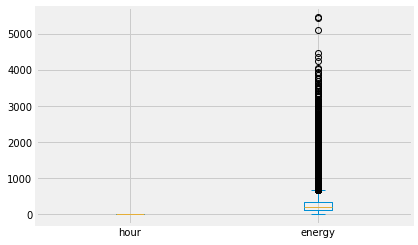

In [210]:
df_hour_pandas.plot(kind='box')

In [218]:
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')
ax= sns.boxplot(x='hour',y='hour',data=df_hour_pandas)
ax = sns.stripplot(x="energy", y="energy",data=df_hour_pandas)

In [208]:
df_hour_pandas

,id,hour,Acorn,Acorn_grouped,energy
0,MAC000032,12,ACORN-Q,Adversity,222.947000100
1,MAC000032,13,ACORN-Q,Adversity,144.688999800
2,MAC000032,14,ACORN-Q,Adversity,104.002999900
3,MAC000032,15,ACORN-Q,Adversity,118.575000100
4,MAC000032,16,ACORN-Q,Adversity,155.270999900
...,...,...,...,...,...
133463,MAC000075,6,ACORN-E,Affluent,141.986000000
133464,MAC002602,12,ACORN-H,Comfortable,170.100000000
133465,MAC002602,13,ACORN-H,Comfortable,202.698000000
133466,MAC002794,6,ACORN-F,Comfortable,263.987000000


In [140]:
#Split the dataset per hour
hour=[]


In [141]:
for i in range (0,23):
    hour.append(df_hour.filter(df4.hour==i))

In [107]:
len(hour)

23

In [146]:
#The List hour has the result for each hour we could estemate the number of clusters  per hour
#Then we could perfor 
hour[1].head()

Row(id='MAC000032', hour=1, Acorn='ACORN-Q', Acorn_grouped='Adversity', sum(kwh)=1674.1389986000015)

In [142]:
pivot_hours_1.count()

6973655

In [147]:
hour[1].printSchema()

root
 |-- id: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- sum(kwh): double (nullable = true)



In [144]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [145]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [151]:
hour[1].columns

['id', 'hour', 'Acorn', 'Acorn_grouped', 'sum(kwh)']

In [155]:
from pyspark.ml.feature import VectorAssembler
hour[1].columns
assemble=VectorAssembler(inputCols=[
'hour', 
'sum(kwh)'],outputCol='features')

In [156]:
hour[1].na.drop()

DataFrame[id: string, hour: int, Acorn: string, Acorn_grouped: string, sum(kwh): double]

In [157]:
assembled_data=assemble.transform(hour[1])


In [160]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+---------+----+-------+-------------+------------------+--------------------+--------------------+
|       id|hour|  Acorn|Acorn_grouped|          sum(kwh)|            features|        standardized|
+---------+----+-------+-------------+------------------+--------------------+--------------------+
|MAC000032|   1|ACORN-Q|    Adversity|1674.1389986000015|[1.0,1674.1389986...|[0.0,5.9357899426...|
|MAC000041|   1|ACORN-Q|    Adversity|124.48200000000075|[1.0,124.48200000...|[0.0,0.4413606064...|
+---------+----+-------+-------------+------------------+--------------------+--------------------+
only showing top 2 rows



# Calculate the mximum number of clusters for Hour1 
We can copy (for loop all steps for all Hours)

In [161]:
silhouette_score=[]

In [162]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [164]:
#this is time consuminig 
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9843067458408903
Silhouette Score: 0.8988498817441941
Silhouette Score: 0.8305990422250449
Silhouette Score: 0.7993193317350042
Silhouette Score: 0.7446610771540234
Silhouette Score: 0.7735031152272831
Silhouette Score: 0.7443834333220759
Silhouette Score: 0.741482683548849


In [167]:
silhouette_score

[0.9843067458408903,
 0.8988498817441941,
 0.8305990422250449,
 0.7993193317350042,
 0.7446610771540234,
 0.7735031152272831,
 0.7443834333220759,
 0.741482683548849]

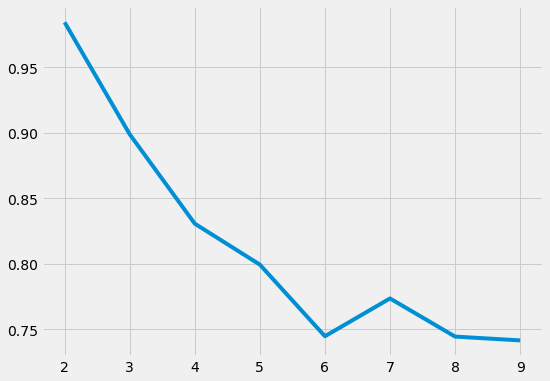

In [169]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)


# I prefer going ahead with K=6 where a local maxima of Silhouette Score is observed. Since there is no correct answer for what value of K is good, we can restore to descriptive statistics and plots to check the distribution 

### the above is very time cosuminig and  i sugest to split four time period (overnight,breakfast,daytime and evening)

In [115]:
from pyspark.ml.clustering import LDA

In [130]:
# Trains a LDA model.

In [131]:
lda = LDA(k=10, maxIter=10)

In [132]:
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)


In [88]:
#Total Rows of pivot 
pivot_hours.count()

3510433

In [90]:
pivot_hours.head(5)

[Row(id='MAC000022', year=2011, month=12, date=7, std='Std', 0=None, 1=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, 10=0.533, 11=0.453, 12=0.41800000000000004, 13=0.426, 14=0.478, 15=0.367, 16=0.495, 17=0.523, 18=0.688, 19=0.591, 20=0.657, 21=0.669, 22=0.772, 23=0.6930000000000001),
 Row(id='MAC000022', year=2011, month=12, date=8, std='Std', 0=0.623, 1=0.604, 2=0.265, 3=0.255, 4=0.259, 5=0.246, 6=0.251, 7=0.241, 8=0.318, 9=0.46399999999999997, 10=0.487, 11=0.378, 12=0.523, 13=0.43600000000000005, 14=0.434, 15=0.361, 16=0.565, 17=0.499, 18=0.6910000000000001, 19=0.586, 20=0.5489999999999999, 21=1.033, 22=1.078, 23=0.635),
 Row(id='MAC000022', year=2011, month=12, date=9, std='Std', 0=0.665, 1=0.6439999999999999, 2=0.47300000000000003, 3=0.269, 4=0.245, 5=0.243, 6=0.245, 7=0.237, 8=0.313, 9=0.321, 10=0.6439999999999999, 11=0.365, 12=0.398, 13=0.51, 14=0.445, 15=0.359, 16=0.528, 17=0.63, 18=0.644, 19=0.621, 20=0.585, 21=0.536, 22=0.614, 23=0.679),
 Row(id='MAC000

In [20]:
type(pivot_hours)

pyspark.sql.dataframe.DataFrame

In [102]:
pivot_hours.writeTo("pivot_hours.csv")

In [103]:
pivot_hours.write.format("csv").save("pivot_hours")

In [ ]:
type(pivot_hours_df)

In [20]:
for i in

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [18]:
from pyspark.sql import functions as f
df_all_statistics=df4.groupby("id","std","year","month","date").agg(f.sum("kwh"),f.avg("kwh"),f.max("kwh"),f.min("kwh"),f.count("kwh"),f.stddev_pop("kwh"))

In [19]:
st=df_all_statistics.toPandas

In [ ]:
#########################
#Aggregate  per Year
######################

In [ ]:
month

In [20]:
Energy_Total= df4.groupby("year").sum("kwh")

In [21]:
Energy_Total_df=Energy_Total.toPandas()

In [ ]:
type(Energy_Total_df)

In [23]:
Energy_Total_df

,year,sum(kwh)
0,2013,1.962773e+07
1,2014,3.333727e+06
2,2012,1.249532e+07
3,2011,1.039318e+05


<AxesSubplot:ylabel='year'>

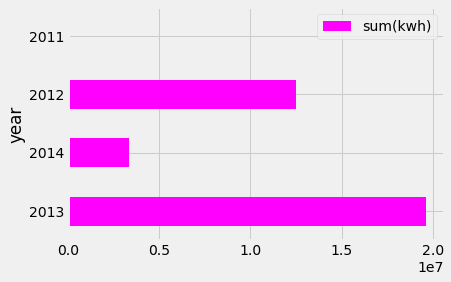

In [148]:
Energy_Total_df.plot(kind='barh',x='year',y='sum(kwh)',colormap='spring')

In [25]:
Energy_Total_hour= df4.groupby("hour").sum("kwh").orderBy("hour")

In [42]:
Energy_Total__hour_df=Energy_Total_hour.toPandas()

In [27]:
Energy_Total__hour_df

,hour,sum(kwh)
0,0,1.239179e+06
1,1,1.012919e+06
2,2,8.718021e+05
3,3,8.060688e+05
4,4,8.017403e+05
5,5,8.784814e+05
6,6,1.098781e+06
7,7,1.346582e+06
8,8,1.491711e+06
9,9,1.508027e+06


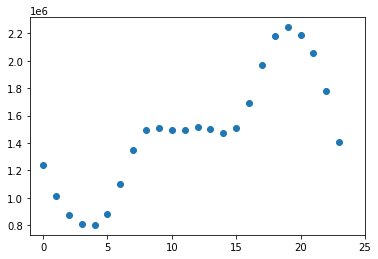

In [46]:
plt.scatter(Energy_Total__hour_df["hour"],Energy_Total__hour_df["sum(kwh)"])
plt.xlim(-1,25);

<AxesSubplot:xlabel='hour'>

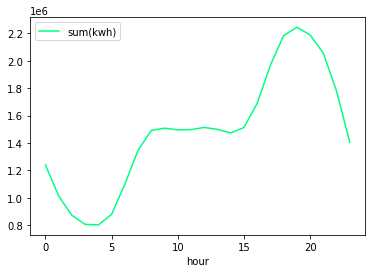

In [28]:
Energy_Total__hour_df.plot(kind='line',x='hour',y='sum(kwh)',colormap='winter_r')

In [29]:
Energy_Total_month= df4.groupby("month").sum("kwh").orderBy("month")

In [30]:
Energy_Total__month_df=Energy_Total_month.toPandas()

In [ ]:
#

In [48]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)


In [49]:
Energy_Total__month_df

,month,sum(kwh)
0,1,4162616.094909619
1,2,3696299.651929513
2,3,2391069.863934288
3,4,2125794.740990511
4,5,2284000.731943930
5,6,2349511.955987025
6,7,2510983.328960049
7,8,2480944.587978223
8,9,2649542.110941831
9,10,3203641.858965589


<AxesSubplot:xlabel='month'>

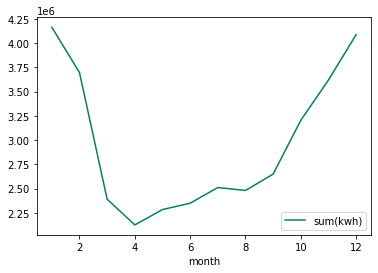

In [50]:
Energy_Total__month_df.plot(kind='line',x='month',y='sum(kwh)',colormap='summer')

In [33]:
#agregate  to dayly energy summurazation 

In [34]:
pivot_Energy = df_4.groupby("id","year","month","date").pivot("hour").sum("kwh")

# Count off all data from  the dnew dataset pivot_Energy

In [51]:
pivot_Energy.count()

3510433

In [53]:
pivot_Energy.printSchema()


root
 |-- id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)



In [56]:
pivot_Energy.head(1)

[Row(id='MAC000002', year=2013, month=1, date=2, 0=0.46399999999999997, 1=0.627, 2=0.49, 3=0.383, 4=0.221, 5=0.217, 6=0.21, 7=0.197, 8=0.21500000000000002, 9=0.694, 10=0.992, 11=0.794, 12=0.404, 13=0.356, 14=0.242, 15=0.731, 16=1.4969999, 17=0.6639999999999999, 18=0.742, 19=0.405, 20=1.228, 21=0.49, 22=0.537, 23=0.5)]

In [65]:
#it will be usehull to aggregate in this stagee with socio economic
#more over we could break the time period (overnight,breakfast and daytime and eveninig )ro represent defferent peak demnd behaviour
#paper 978-1-5386-1495-2/18

In [67]:
plt.style.use('fivethirtyeight')

In [68]:
pivot_Energy.set_index("label", drop=True,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'set_index'

In [69]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

In [63]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10, initializationMode="random")

NameError: name 'parsedData' is not defined

In [ ]:
#first we aggregate in hours , in this data set we have every half hour so we sum every hour
# In the Eveddent dataset we do not need to aggredate every hour
df_all8=df5.groupby("id","std","year","month","date","hour").sum("kwh")
#make ne aggregation per data


from pyspark.sql import functions as f

#create agragate columns for one day avg/max.min/standard division and sum of energy 
df_all_statistics=df5.groupby("id","std","year","month","date").agg(f.sum("kwh"),f.avg("kwh"),f.max("kwh"),f.min("kwh"),f.count("kwh"),f.stddev_pop("kwh"))


In [55]:
df_all_statistics

DataFrame[id: string, std: string, year: int, month: int, date: int, sum(kwh): double, avg(kwh): double, max(kwh): double, min(kwh): double, count(kwh): bigint, stddev_pop(kwh): double]

In [54]:
for i in pivot_df.head(5):
    print(i)

NameError: name 'pivot_df' is not defined

In [ ]:
#print the df
df_all_statistics.head(5)

In [ ]:
print("test")

In [ ]:
#The previous print for better visual each row
for i in df_all_statistics.head(5):
    print(i)

**df_all_statistics is the final dayly aggregation**

In [ ]:
#df_all_statistics is the final dayly aggregation
df_all_statistics.count()

In [ ]:
print("Before casting")
df7.printSchema()




In [ ]:
#df_all_hours=df_all8.withColumn("hours",df_all8['hour'].cast('integer'))
#print("After casting")
#df_all_hours.printSchema()
pivot_df_all=df7.groupby("id","year","month","date").pivot("hour").sum("kwh")
#dataset = pivot_df_all.groupby("id","year","month","date").sum("sum(kwh)").avg("sum(kwh)")("sum(kwh)").min("sum(kwh)").count("sum(kwh)").std("sum(kwh)")

pivot_df_all.count()

In [73]:
pivot_df_all.show()

+---------+----+-----+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+
|       id|year|month|date|                  0|                  1|                  2|                  3|                  4|                  5|                  6|                  7|                  8|                 9|                 10|                 11|                 12|                 13|                 14|                 15|                 16|                 17|                 18|                19|                 20|                 21|                22|           

In [ ]:
#pivot_df is the final dayly dataset with data schema

In [ ]:
pivot_df_all.print

In [ ]:
#moreover the pivot dayly has the hourly energy consumtin at coloums and there is a coloumn with the total energy consumtion

In [45]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt


import pandas as pd

from datetime import datetime
import calendar
import warnings
warnings.filterwarnings("ignore")


In [46]:

# Reading Household info data
df_houtio sehold = pd.read_csv("data/add/informations_households.csv", encoding="utf-8")

#household convert spark  dataframe
householdd=spark.createDataFrame(df_household)

In [47]:
df_4=df3.withColumn("kwh", df3.kwh.cast('double'))
#Join two DataSet
df4=df3.join(householdd, df3.id == householdd.LCLid, 'left')

df5=df4.withColumn("kwh", df4.kwh.cast('double'))

dff_2012=df5.filter(df5.year=='2012')
dff_2013=df5.filter(df5.year=='2013')
dff_2014=df5.filter(df5.year=='2014')


In [48]:



df8_hours=dff_2012.withColumn("hours",dff_2012['hour'].cast('integer'))


Energy_Total2012 = dff_2012.groupby("year").sum("kwh")


In [49]:

#aggragate function and hours cosumtion at coloumns
pivot_df_2012 = df_4.groupby("id","year","month","date").pivot("hour").sum("kwh")

pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [72]:
Energy_Months2012

,month,sum(kwh)
0,1,187845.99499
1,2,280490.43099
2,3,354919.33499
3,4,497697.70101
4,5,803443.58199
5,6,1011463.46600
6,7,1188737.91597
7,8,1195059.26099
8,9,1274225.74199
9,10,1671514.69801


<AxesSubplot:ylabel='month'>

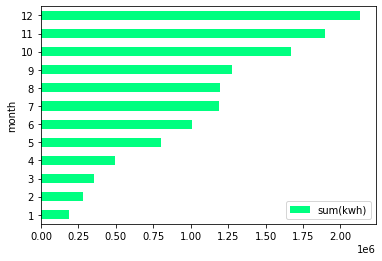

In [50]:
Energy_Months2012 = dff_2012.groupby("month").sum("kwh").orderBy("month").toPandas()

Energy_Months2012.plot(kind='barh',x='month',y='sum(kwh)',colormap='winter_r')




In [51]:
plt.show()


In [60]:
Energy_Months2012["month"]


,month,sum(kwh)
0,1,187845.99499
1,2,280490.43099
2,3,354919.33499
3,4,497697.70101
4,5,803443.58199
5,6,1011463.46600
6,7,1188737.91597
7,8,1195059.26099
8,9,1274225.74199
9,10,1671514.69801


NameError: name 'Energy_Months2012' is not defined

In [61]:
Energy_Months2012["sum(kwh)"]

0     187845.99499
1     280490.43099
2     354919.33499
3     497697.70101
4     803443.58199
5    1011463.46600
6    1188737.91597
7    1195059.26099
8    1274225.74199
9    1671514.69801
10   1900102.99995
11   2129816.48496
Name: sum(kwh), dtype: float64

In [62]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

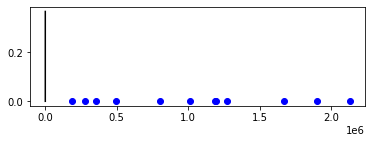

In [65]:
plt.figure()
plt.subplot(211)
plt.plot(Energy_Months2012["sum(kwh)"], f(Energy_Months2012["sum(kwh)"]), 'bo', Energy_Months2012["month"], f(Energy_Months2012["month"]), 'k')

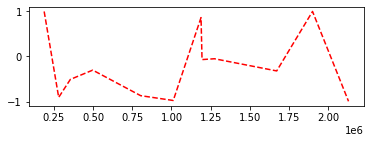

In [66]:
plt.subplot(212)
plt.plot(Energy_Months2012["sum(kwh)"], np.cos(2*np.pi*Energy_Months2012["sum(kwh)"]), 'r--')
plt.show()

<AxesSubplot:xlabel='month'>

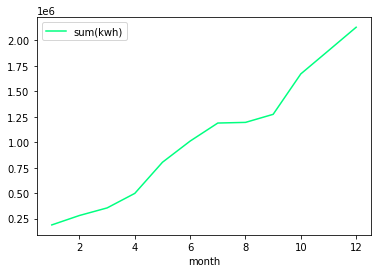

In [67]:
Energy_Months2012.plot(kind='line',x='month',y='sum(kwh)',colormap='winter_r')

In [ ]:
k